# PyTorch Hypercolumn CNN  for Zurich Dataset

In [1]:
# import libraries
import os, sys
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

# custom libraries
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package
from helpers.data_loader import ZurichLoader
from helpers.helpers import *

In [2]:
base_dir = '/raid/home/cwendl'  # for guanabana
root_dir = base_dir + '/SIE-Master/Zurich'
patch_size = 64
class_to_remove = 1

# load data
dataset_train = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=patch_size, transform='augment', 
                             random_crop=True, class_to_remove=class_to_remove)

dataset_val = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=patch_size, class_to_remove=class_to_remove)
dataset_test = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=patch_size)

dataloader_train = DataLoader(dataset_train, batch_size=100, shuffle=True, num_workers=20)
dataloader_val = DataLoader(dataset_val, batch_size=100, shuffle=False, num_workers=20)
dataloader_test = DataLoader(dataset_test, batch_size=100, shuffle=False, num_workers=20)

In [3]:
class HyperColumn(nn.Module):
    def __init__(self, in_dim, out_dim, n_filters, act=nn.ReLU, patch_size=128):
        super(HyperColumn, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.n_filters = n_filters
        self.act = act()

        self.down_1 = self.conv_block(self.in_dim, self.n_filters, self.act)
        self.down_2 = self.conv_block(self.n_filters, self.n_filters * 2, self.act)
        self.down_3 = self.conv_block(self.n_filters * 2, self.n_filters * 4, self.act)
        self.down_4 = self.conv_block(self.n_filters * 4, self.n_filters * 8, self.act)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.upsample = nn.Upsample(size=[patch_size, patch_size], mode='bilinear', align_corners=True)

        dim_end = self.in_dim + sum(self.n_filters * [1, 2, 4, 8])
        self.out = nn.Sequential(
            nn.Dropout(.5),
            nn.Conv2d(dim_end, dim_end, kernel_size=1, stride=1),
            self.act,
            nn.Conv2d(dim_end, self.out_dim, kernel_size=1, stride=1)
        )

    def conv_block(self, dim_in, dim_out, act, kernel_size=3, stride=1, padding=0):
        return nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(dim_out),
            act
        )

    def forward(self, input):
        down_1 = self.down_1(input)
        pool_1 = self.pool(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool(down_4)

        pool_1 = self.upsample(pool_1)
        pool_2 = self.upsample(pool_2)
        pool_3 = self.upsample(pool_3)
        pool_4 = self.upsample(pool_4)

        cat_l = torch.cat([input, pool_1, pool_2, pool_3, pool_4], dim=1)

        out = self.out(cat_l)
        if self.training:
            out = nn.LogSoftmax(dim=1)(out)
        else:
            out = nn.Softmax(dim=1)(out)
        return out

    
def acc_with_filt(y_true, y_pred, label_to_ignore):
    """
    get accuracy ignoring a label in y_true
    :param y_true: ground truth (tensor)
    :param y_pred: predicted label (tensor)
    :param label_to_ignore: label to ignore
    :return: accuracy
    """
    y_true = y_true.numpy().flatten()
    y_pred = y_pred.numpy().flatten()
    filt = y_true != label_to_ignore
    return np.sum(np.equal(y_pred[filt], y_true[filt]))/len(y_true[filt])


def test(model, f_loss, dataloader_train, dataloader_val, verbosity=False):
    with torch.no_grad():
        model.eval()
        acc_tr_val, loss_tr_val = [], []
        for dataloader, name in zip([dataloader_train, dataloader_val], ['Training', 'Validation']):
            loss = 0
            acc = []  # average accuracy
            for i_batch, (im, gt) in enumerate(dataloader):
                im = im.cuda()
                gt = gt.cuda()
                output = model(im)
                loss += f_loss(output, gt).cpu()
                _, pred = output.cpu().max(1, keepdim=True)
                acc.append(acc_with_filt(gt.cpu(), pred.cpu(), 0))
                #correct += float(pred.eq(gt.cpu().view_as(pred)).sum()) / (64.0 ** 2)
                #print(correct)

            loss /= len(dataloader.dataset)
            accuracy = np.mean(acc)
            acc_tr_val.append(accuracy)
            loss_tr_val.append(loss)
            if verbosity>0:
                print(name + ' set: Average loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(loss, accuracy * 100))
        return acc_tr_val[0], acc_tr_val[1], loss_tr_val[0], loss_tr_val[1]

def predict(model, dataloader_pred):
    with torch.no_grad():
        model.eval()
        test_pred = torch.LongTensor()
        for i_batch, (im, gt) in enumerate(dataloader_pred):
            im = im.cuda()
            gt = gt.cuda()
            output = model(im)
            _, pred = output.cpu().max(1, keepdim=False)
            test_pred = torch.cat((test_pred, pred), dim=0)
    return test_pred


def train(model, dataloader_train, dataloader_val, epochs, verbosity=0, plot=False, verbose=False):
    """
    Train a model for a given number of epochs
    :param model: Model to train
    :param dataloader_train: dataloader for training data
    :param dataloader_val: dataloader for test data
    :param epochs: number of epochs to train
    :param verbosity: verbosity level of status messages
    :return:
    """
    opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    # weights = torch.from_numpy(dataset_train.weights).float().cuda()
    f_loss = nn.NLLLoss(ignore_index=0)
    model.train()
    acc_tr_hist, acc_val_hist = [], []
    loss_tr_hist, loss_val_hist = [], []
    for epoch in range(epochs):
        # validation
        av_loss = 0

        for i_batch, (im, gt) in (tqdm(enumerate(dataloader_train)) if verbosity>1 else enumerate(dataloader_train)):
            im = im.cuda()
            gt = gt.cuda()
            opt.zero_grad()
            output = model(im)
            loss_out = f_loss(output, gt)
            av_loss += loss_out.cpu().detach().numpy()
            loss_out.backward()
            opt.step()

            if not i_batch % 100 and verbosity > 1:
                tqdm.write("Average loss: {:.2f}".format(av_loss/(i_batch+1)))

            # log to tensorboard
            # info = {'loss': av_loss, 'accuracy': accuracy, i_batch
        if verbosity>0:
            print("Epoch %i:" % epoch)
        acc_tr, acc_val, loss_tr, loss_val = test(model, f_loss, dataloader_train, dataloader_val, verbosity=verbosity)
        acc_tr_hist.append(acc_tr)
        acc_val_hist.append(acc_val)
        loss_tr_hist.append(loss_tr)
        loss_val_hist.append(loss_val)
        if plot:
            # plot accuracy history
            fig, ax = plt.subplots(1,1)
            ax.plot(np.arange(epoch+1), acc_tr_hist)
            ax.plot(np.arange(epoch+1), acc_val_hist)
            ax.set_xlabel("Epochs")
            ax.set_ylabel("OA")
            ax.set_ylim([0,1])
            ax.grid(alpha=.3)
            fig.axes[0].spines['right'].set_visible(False)
            fig.axes[0].spines['top'].set_visible(False)
            ax.legend(['Training Set', 'Validation Set'])
            plt.savefig('Figures/hist_wo_cl_' + str(class_to_remove) + '_train_all_acc.pdf')
            plt.close()
            
            # plot loss history
            fig, ax = plt.subplots(1,1)
            ax.plot(np.arange(epoch+1), loss_tr_hist)
            ax.plot(np.arange(epoch+1), loss_val_hist)
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
            ax.grid(alpha=.3)
            fig.axes[0].spines['right'].set_visible(False)
            fig.axes[0].spines['top'].set_visible(False)
            ax.legend(['Training Set','Validation Set'])
            plt.savefig('Figures/hist_wo_cl_' + str(class_to_remove) + '_train_all_loss.pdf')
            plt.close()

In [4]:
model = HyperColumn(in_dim=4, out_dim=9, n_filters=32, patch_size=patch_size).cuda()

In [5]:
train(model, dataloader_train, dataloader_val, epochs=50, verbosity=1, plot=True)

Epoch 0:
Training set: Average loss: -0.0038, Accuracy: 67.86%
Validation set: Average loss: -0.0032, Accuracy: 52.93%
Epoch 1:
Training set: Average loss: -0.0080, Accuracy: 79.42%
Validation set: Average loss: -0.0070, Accuracy: 69.80%
Epoch 2:
Training set: Average loss: -0.0082, Accuracy: 81.27%
Validation set: Average loss: -0.0072, Accuracy: 71.68%
Epoch 3:
Training set: Average loss: -0.0084, Accuracy: 82.98%
Validation set: Average loss: -0.0073, Accuracy: 73.06%
Epoch 4:
Training set: Average loss: -0.0084, Accuracy: 83.66%
Validation set: Average loss: -0.0074, Accuracy: 73.34%
Epoch 5:
Training set: Average loss: -0.0085, Accuracy: 84.02%
Validation set: Average loss: -0.0074, Accuracy: 73.63%
Epoch 6:
Training set: Average loss: -0.0085, Accuracy: 84.27%
Validation set: Average loss: -0.0075, Accuracy: 73.93%
Epoch 7:
Training set: Average loss: -0.0086, Accuracy: 84.50%
Validation set: Average loss: -0.0075, Accuracy: 74.22%
Epoch 8:
Training set: Average loss: -0.0086, Ac

In [6]:
# load data with overlap
dataset_train_overlap = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=int(patch_size/2))
dataset_val_overlap = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=int(patch_size/2))
dataset_test_overlap = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=int(patch_size/2))

dataloader_train_overlap = DataLoader(dataset_train_overlap, batch_size=10, shuffle=False, num_workers=20)
dataloader_val_overlap = DataLoader(dataset_val_overlap, batch_size=10, shuffle=False, num_workers=20)
dataloader_test_overlap = DataLoader(dataset_test_overlap, batch_size=10, shuffle=False, num_workers=20)

In [10]:
# predict (with overlap)
preds = predict(model, dataloader_val_overlap)

# TODO remove overlap, put into patches

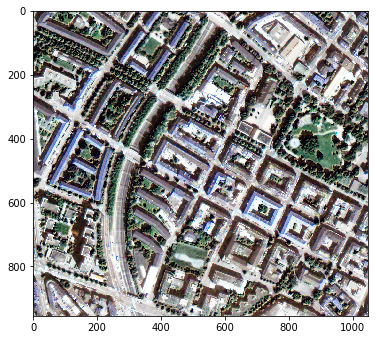

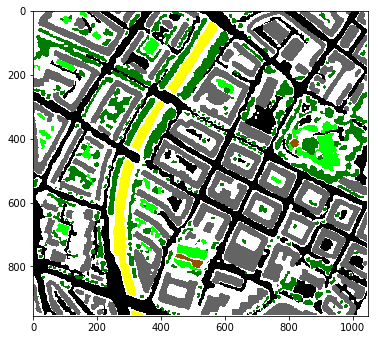

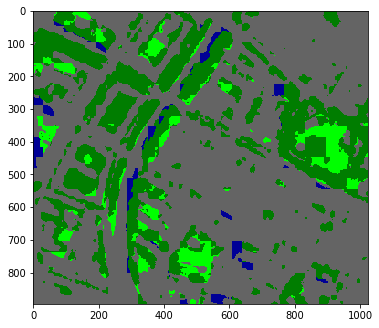

In [30]:
img_idx = 2

img = convert_patches_to_image(dataset_val.imgs, preds[..., np.newaxis], img_idx, patch_size, int(patch_size/2), 0)

# im
plt.figure(figsize=(6, 6))
plt.imshow(dataset_val.imgs[img_idx][..., :3])
plt.show()

# gt
plt.figure(figsize=(6, 6))
plt.imshow(gt_label_to_color(dataset_val.gt[img_idx], dataset_val.colors)*255)
plt.show()

# pred
plt.figure(figsize=(6, 6))
plt.imshow(gt_label_to_color(img[...,0], dataset_val.colors)*255)

In [22]:
p = test(model, f_loss, dataloader_train, dataloader_val, verbosity=1)

Training set: Average loss: -0.0100, Accuracy: 94.80%
Validation set: Average loss: -0.0093, Accuracy: 85.66%


In [23]:
#preds_val = predict(model, dataloader_val)
#preds_train = predict(model, dataloader_train)

# save model
state = {
    'model': model.state_dict(),
    'n_epochs': 60,
    'loss_train': 0.0  # TODO change
}
torch.save(state, 'models/model_wo_cl_' + str(class_to_remove) + '.pytorch')

In [24]:
state = torch.load('models/model_wo_cl_' + str(class_to_remove) + '.pytorch')
model.load_state_dict(state['model'])